In [1]:
import glob
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import numpy as np
import scienceplots
import soundfile as sf

plt.style.use(['science', 'ieee'])

## Audio length bar plot

In [2]:
audio_lengths = []

for audio_file in tqdm(glob.glob('../data/tsrc/**/*.wav', recursive=True)):
    audio_file = Path(audio_file)
    word = audio_file.parent.stem

    if word == "_background_noise_":
        continue

    info = sf.info(audio_file)
    audio_length = info.frames / info.samplerate
    audio_lengths.append([word, audio_length])

df_audio_lengths = pd.DataFrame(audio_lengths, columns=["Word", "Audio_Length"])

100%|██████████| 64727/64727 [08:12<00:00, 131.30it/s]


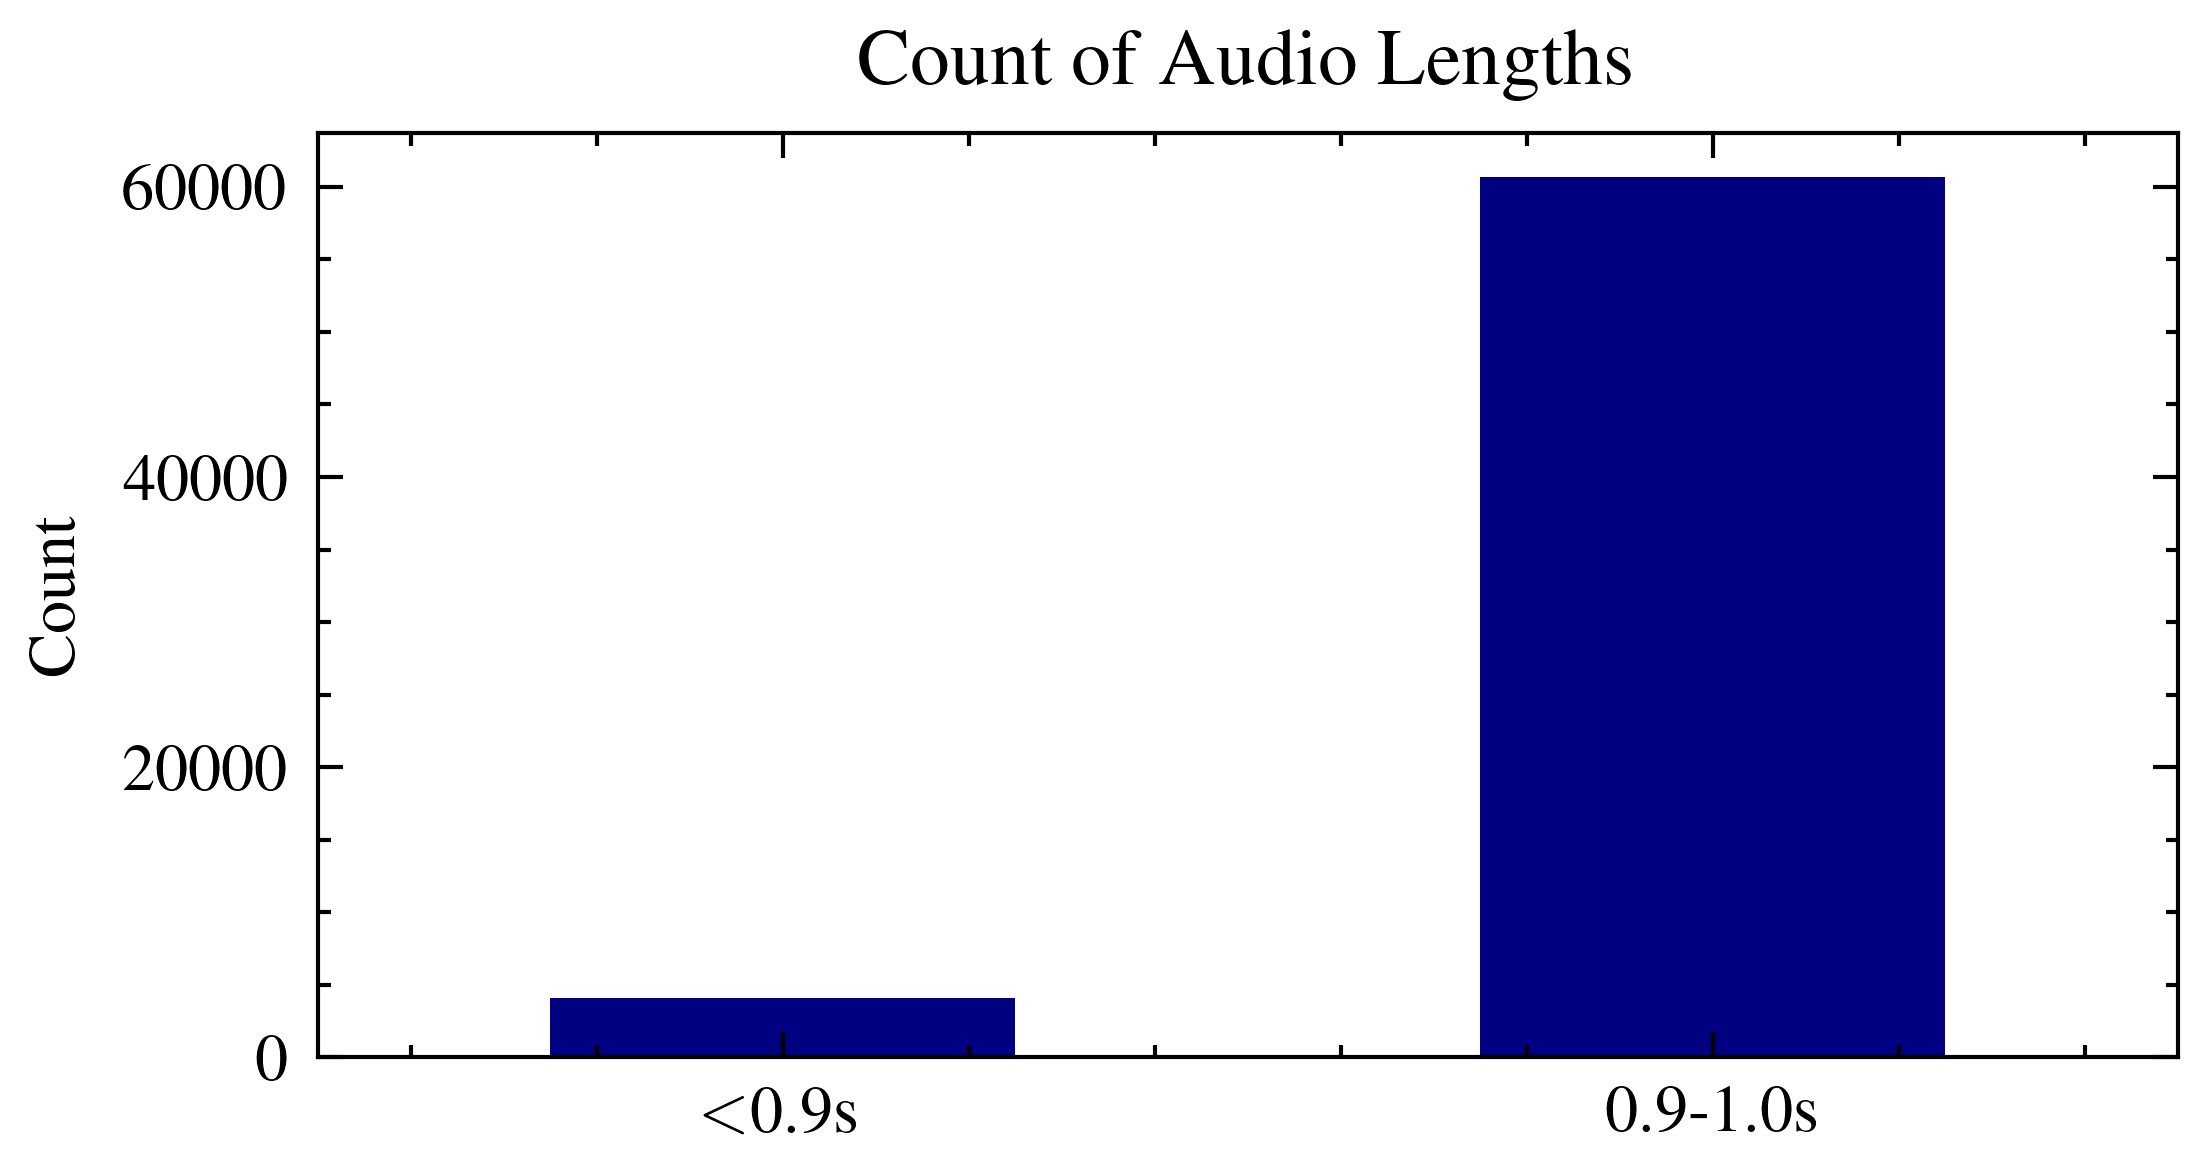

In [38]:
df_audio_lengths['Length_Category'] = np.where(df_audio_lengths['Audio_Length'] < 0.9, '$<$0.9s', '0.9-1.0s')

df_audio_lengths['Length_Category'].value_counts().sort_values().plot(kind='bar', color='navy', figsize=(4,2))
plt.title('Count of Audio Lengths')
plt.xlabel('')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.savefig('charts/audio_lengths.png', dpi=300)
plt.show()

## Boxplots

In [65]:
amplitudes = []

for audio_file in tqdm(glob.glob('../data/tsrc/train/audio/**/*.wav')):
    audio_file = Path(audio_file)
    word = audio_file.parent.stem

    if word == "_background_noise_":
        continue

    audio_data, sample_rate = sf.read(audio_file)
    mean_amplitude = np.mean(np.abs(audio_data))
    amplitudes.append([word, mean_amplitude])

df_amplitudes = pd.DataFrame(amplitudes, columns=["Word", "Mean_Amplitude"])

100%|██████████| 64727/64727 [10:23<00:00, 103.88it/s]


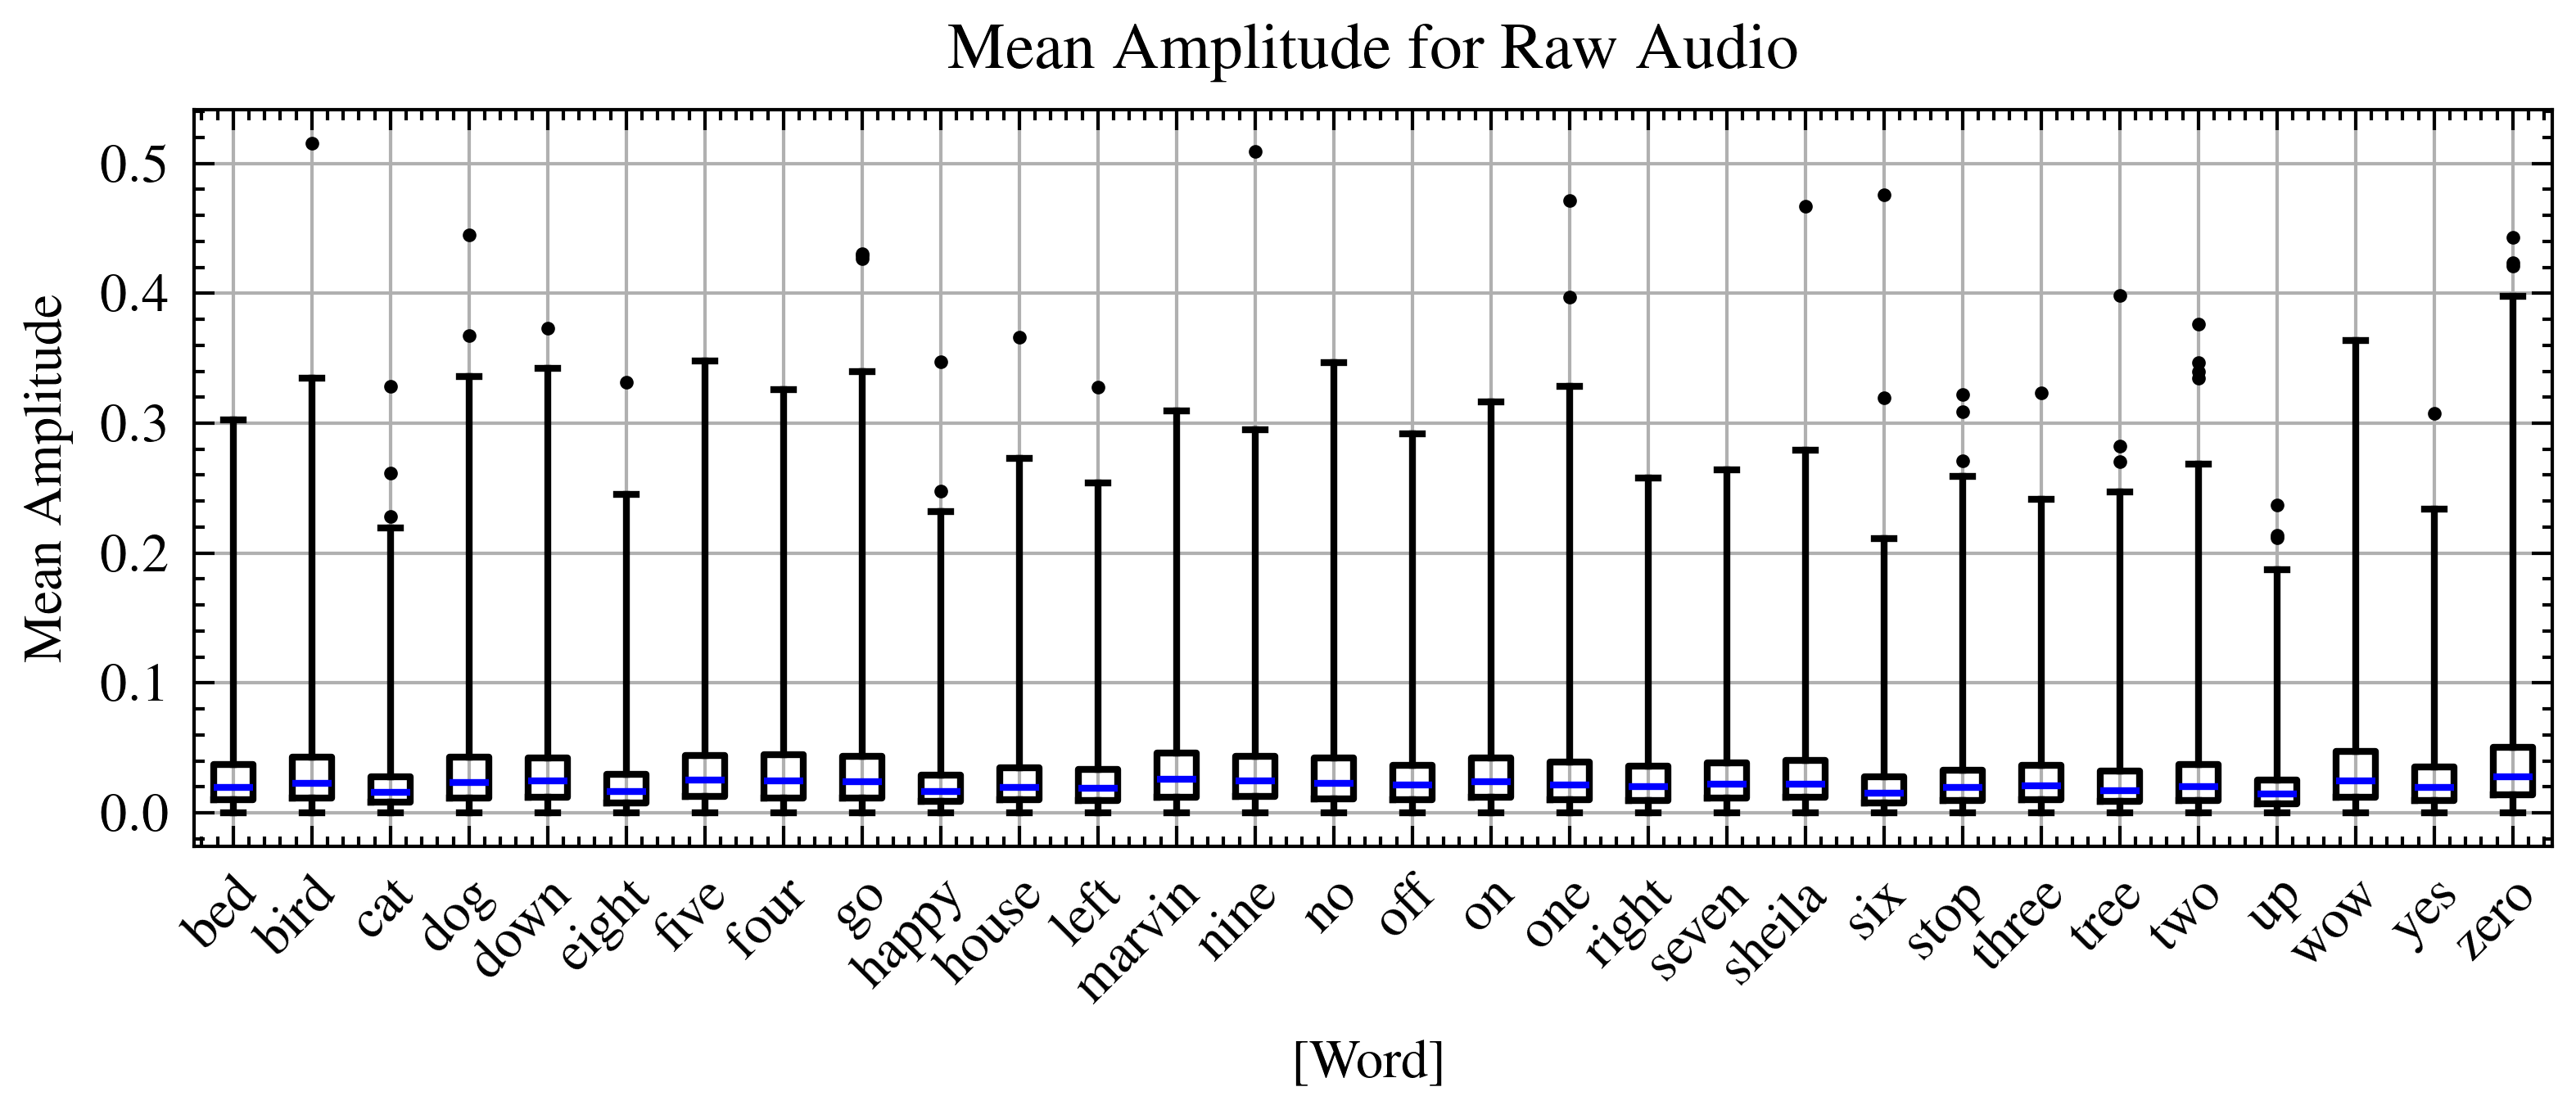

In [66]:
df_amplitudes.boxplot(by="Word", figsize=(6, 2), whis=10, flierprops=dict(marker='o', markersize=1))
plt.suptitle('')
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.ylabel("Mean Amplitude")
plt.title('Mean Amplitude for Raw Audio')
plt.savefig('charts/mean_amplitude_raw_audio.png', dpi=300)
plt.show()

In [62]:
amplitudes = []

for audio_file in tqdm(glob.glob('../data/tsrc_cleaned/**/*.wav', recursive=True)):
    audio_file = Path(audio_file)
    word = audio_file.parent.stem

    if word == "_background_noise_":
        continue

    audio_data, sample_rate = sf.read(audio_file)
    mean_amplitude = np.mean(np.abs(audio_data))
    amplitudes.append([word, mean_amplitude])

df_amplitudes = pd.DataFrame(amplitudes, columns=["Word", "Mean_Amplitude"])

 28%|██▊       | 28532/102674 [04:42<13:43, 90.04it/s] e:\MINI8\ITM\intro-to-ml\venv\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\MINI8\ITM\intro-to-ml\venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 102674/102674 [17:17<00:00, 98.98it/s] 


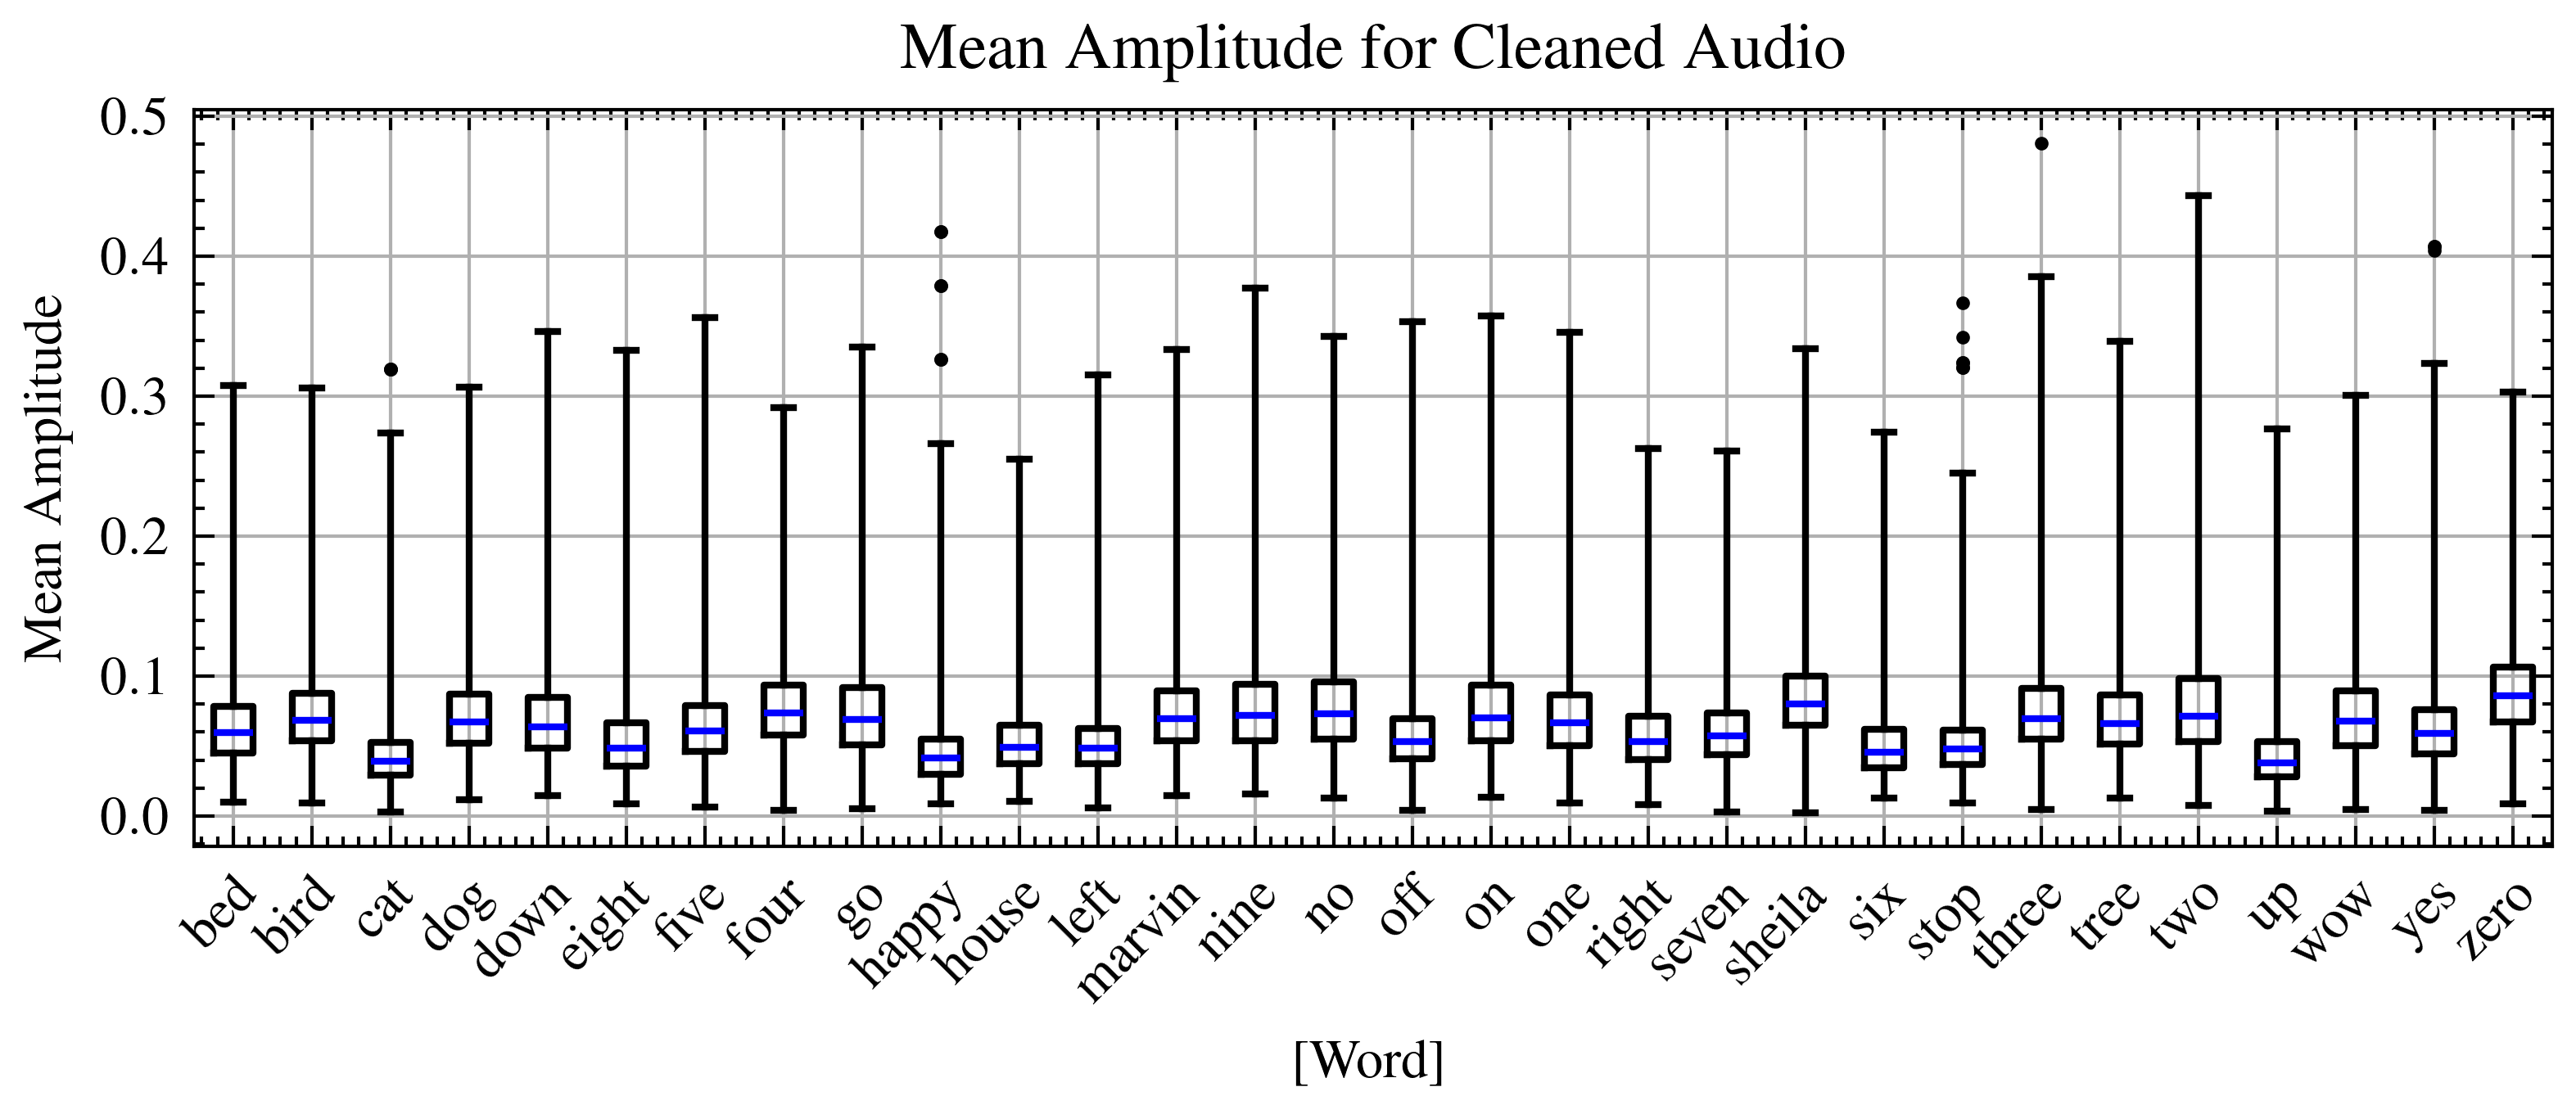

In [64]:
df_amplitudes.boxplot(by="Word", figsize=(6, 2), whis=10, flierprops=dict(marker='o', markersize=1))
plt.suptitle('')
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.ylabel("Mean Amplitude")
plt.title('Mean Amplitude for Cleaned Audio')
plt.savefig('charts/mean_amplitude_cleaned_audio.png', dpi=300)
plt.show()

## RGB histograms 

### Before cleaning

In [2]:
black_threshold = 5
data_path = '../data/tsrc_spectrograms'


r_combined = np.zeros(256)
g_combined = np.zeros(256)
b_combined = np.zeros(256)

image_files = glob.glob(str(Path(data_path) / '**' / '*.png'), recursive=True)

for image_file in tqdm(image_files):
    img_path = Path(image_file)
    class_name = img_path.parent.stem
    
    if class_name == "_background_noise_":
        continue
    
    try:
        img = np.array(Image.open(img_path))
        
        non_black_mask = (img[:,:,0] > black_threshold) | \
                        (img[:,:,1] > black_threshold) | \
                        (img[:,:,2] > black_threshold)
        
        r_filtered = img[:,:,0][non_black_mask]
        g_filtered = img[:,:,1][non_black_mask]
        b_filtered = img[:,:,2][non_black_mask]
        
        r_hist = np.histogram(r_filtered, bins=256, range=(0,256))[0]
        g_hist = np.histogram(g_filtered, bins=256, range=(0,256))[0]
        b_hist = np.histogram(b_filtered, bins=256, range=(0,256))[0]
        
        r_combined += r_hist
        g_combined += g_hist
        b_combined += b_hist
        
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        continue

100%|██████████| 64721/64721 [09:34<00:00, 112.70it/s]


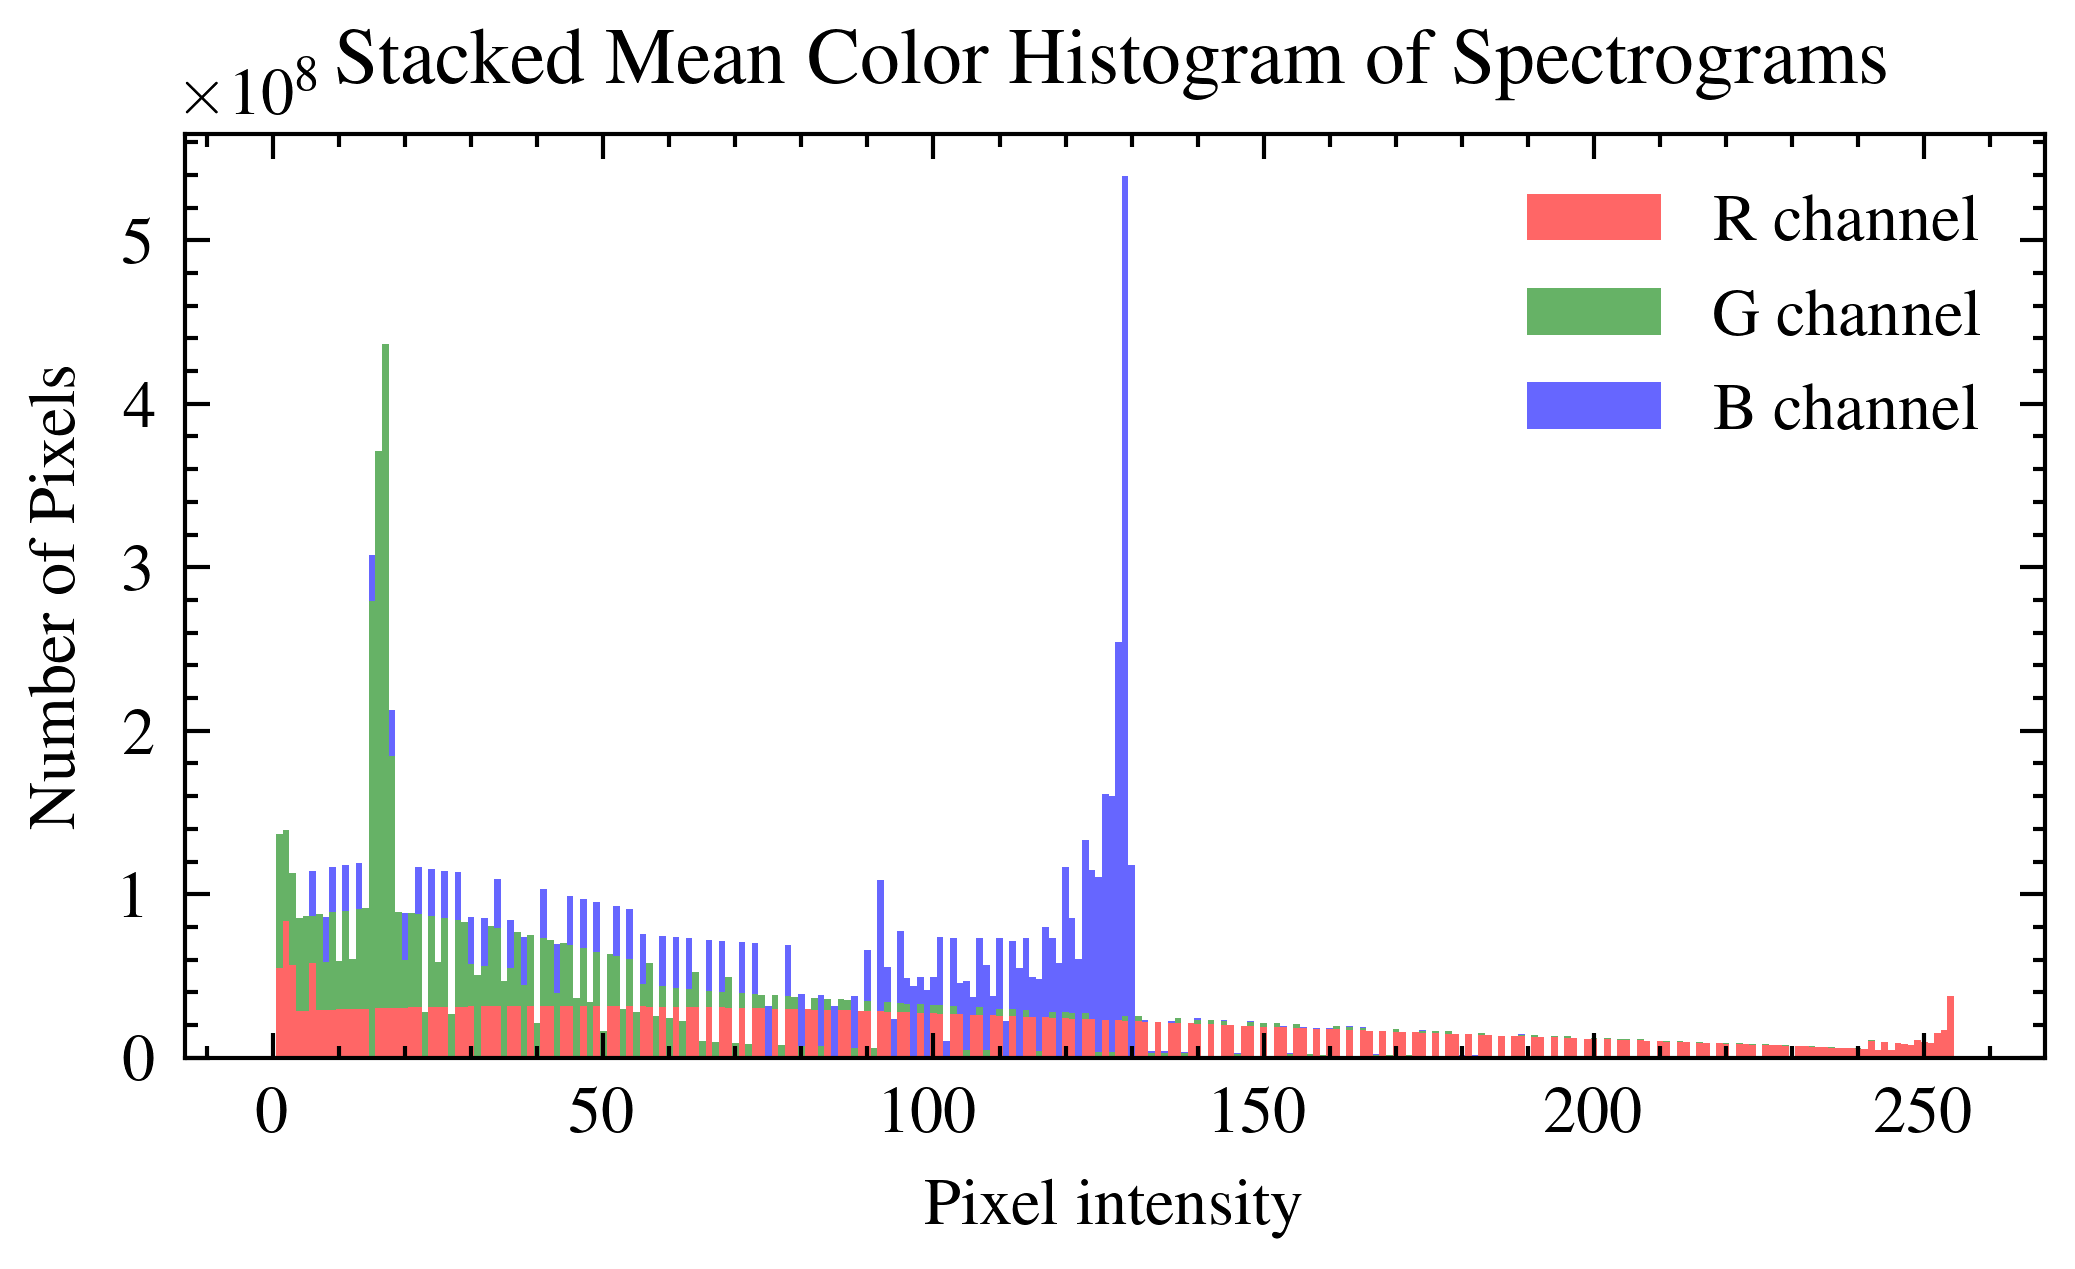

In [37]:
plt.figure(figsize=(4, 2))
x_values = np.arange(256)

plt.bar(x_values, r_combined, color='red', label='R channel', width=1.0, alpha=0.6)
plt.bar(x_values, g_combined, color='green', label='G channel', width=1.0, alpha=0.6, bottom=r_combined)
plt.bar(x_values, b_combined, color='blue', label='B channel', width=1.0, alpha=0.6, bottom=r_combined + g_combined)

plt.title(f'Stacked Mean Color Histogram of Spectrograms')
plt.xlabel('Pixel intensity')
plt.ylabel('Number of Pixels')
plt.legend()
plt.grid(False)

plt.ylim(0, max(max(r_combined), max(g_combined), max(b_combined)) * 1.1)
plt.savefig('charts/mean_color_histogram.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

### Cleaning difference

In [12]:
black_threshold = 5
data_path = '../data/tsrc_spectrograms_cleaned'


r_cleaned_combined = np.zeros(256)
g_cleaned_combined = np.zeros(256)
b_cleaned_combined = np.zeros(256)

image_files = glob.glob(str(Path(data_path) / '**' / '*.png'), recursive=True)

for image_file in tqdm(image_files):
    img_path = Path(image_file)
    class_name = img_path.parent.stem
    
    if class_name == "_background_noise_":
        continue
    
    try:
        img = np.array(Image.open(img_path))
        
        non_black_mask = (img[:,:,0] > black_threshold) | \
                        (img[:,:,1] > black_threshold) | \
                        (img[:,:,2] > black_threshold)
        
        r_filtered = img[:,:,0][non_black_mask]
        g_filtered = img[:,:,1][non_black_mask]
        b_filtered = img[:,:,2][non_black_mask]
        
        r_hist = np.histogram(r_filtered, bins=256, range=(0,256))[0]
        g_hist = np.histogram(g_filtered, bins=256, range=(0,256))[0]
        b_hist = np.histogram(b_filtered, bins=256, range=(0,256))[0]
        
        r_cleaned_combined += r_hist
        g_cleaned_combined += g_hist
        b_cleaned_combined += b_hist
        
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        continue

100%|██████████| 64721/64721 [09:06<00:00, 118.43it/s]


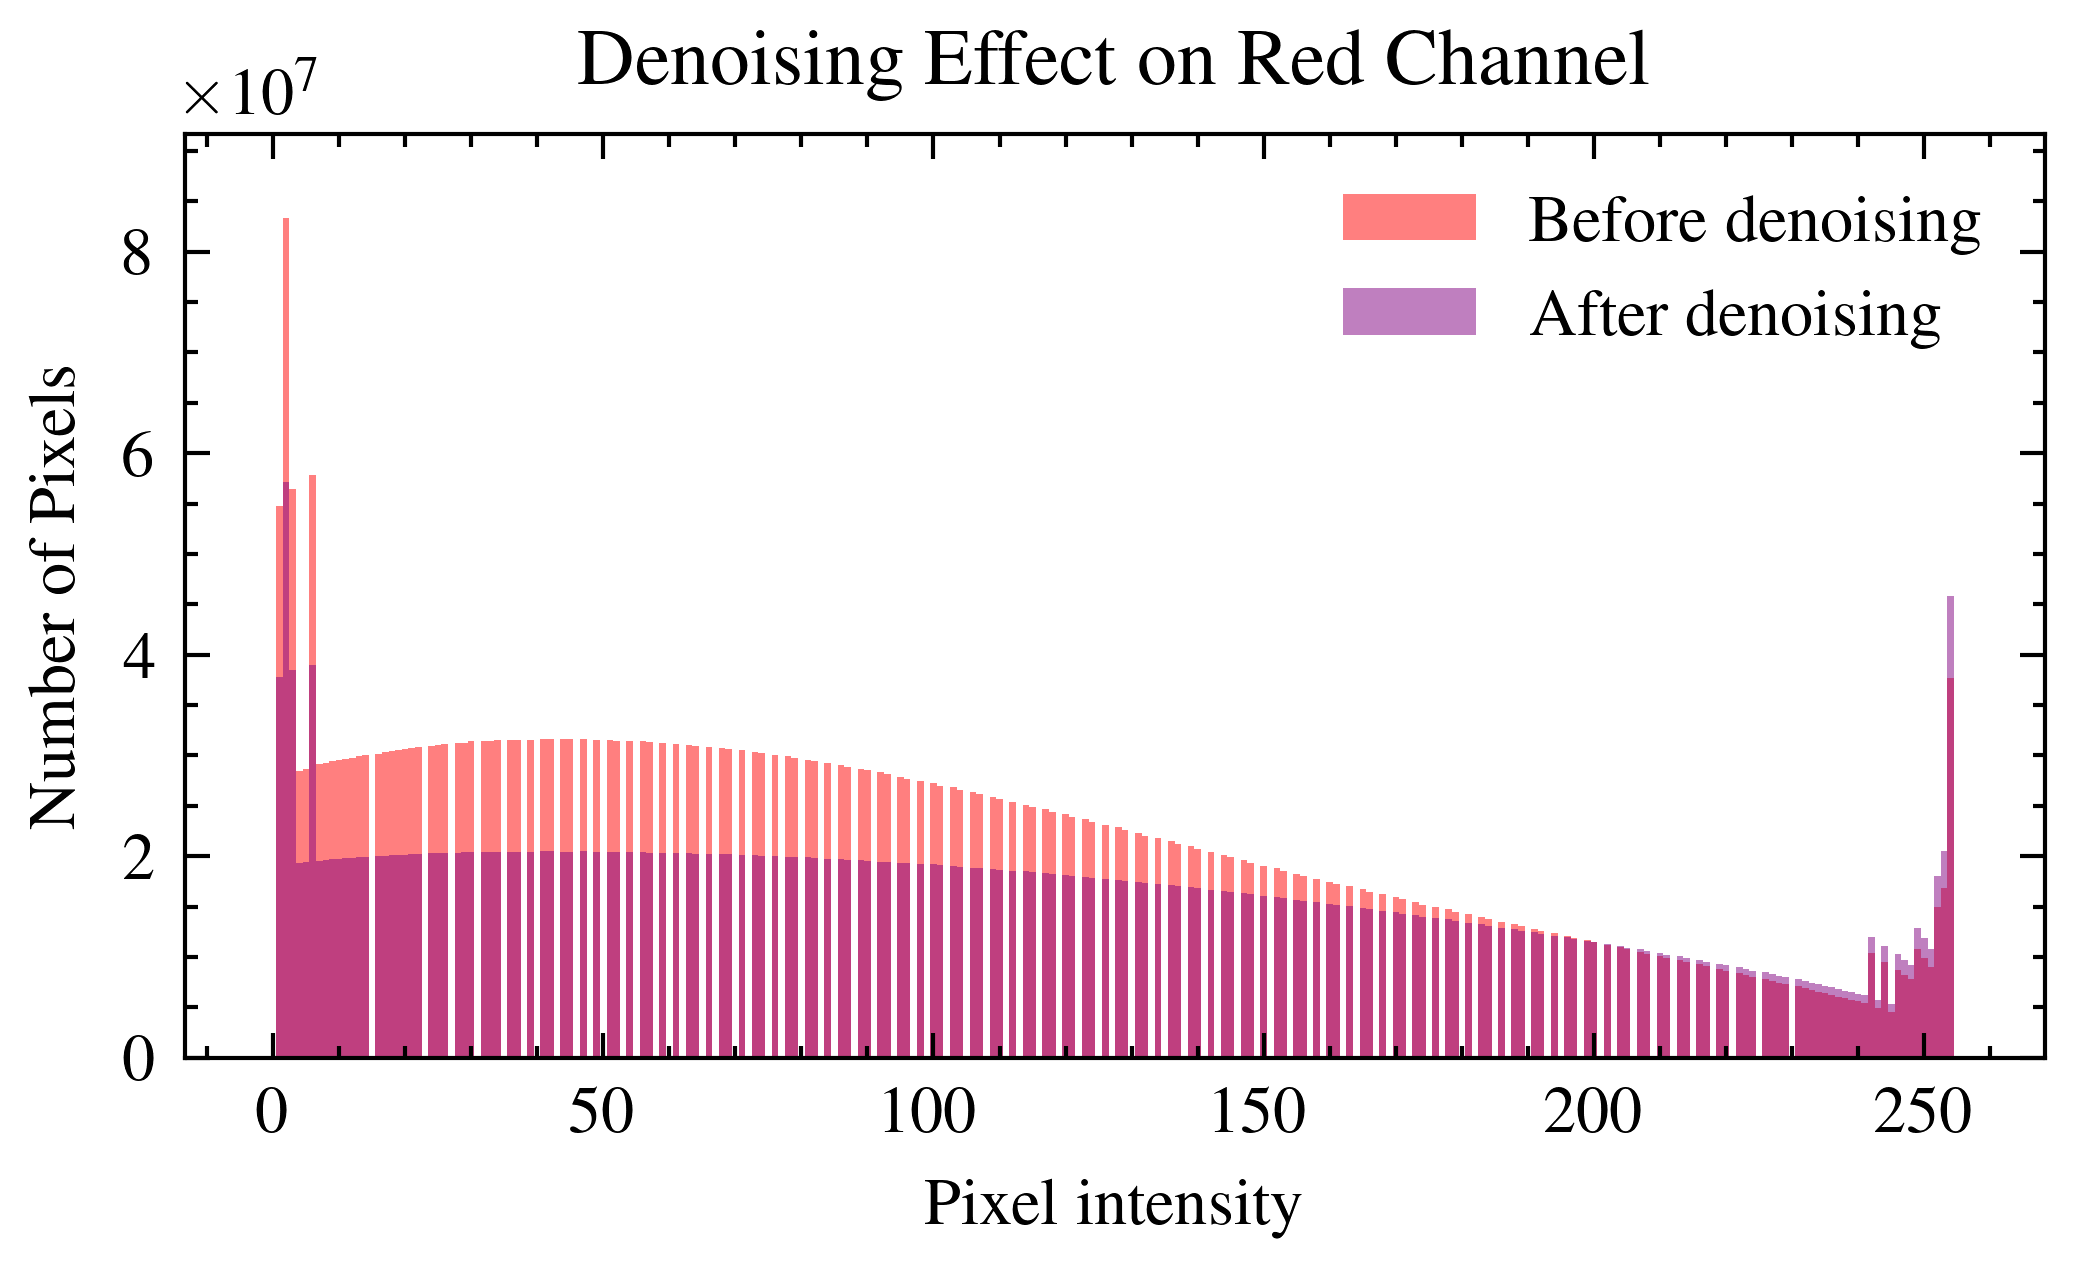

In [35]:
plt.figure(figsize=(4, 2))
x_values = np.arange(256)

plt.bar(x_values, r_combined, color='red', label='Before denoising', width=1.0, alpha=0.5)
plt.bar(x_values, r_cleaned_combined, color='purple', label='After denoising', width=1.0, alpha=0.5)

plt.title(f'Denoising Effect on Red Channel')
plt.xlabel('Pixel intensity')
plt.ylabel('Number of Pixels')
plt.legend()
plt.grid(False)

plt.ylim(0, max(max(r_combined), max(r_cleaned_combined)) * 1.1)
plt.savefig('charts/red_channel_denoising.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

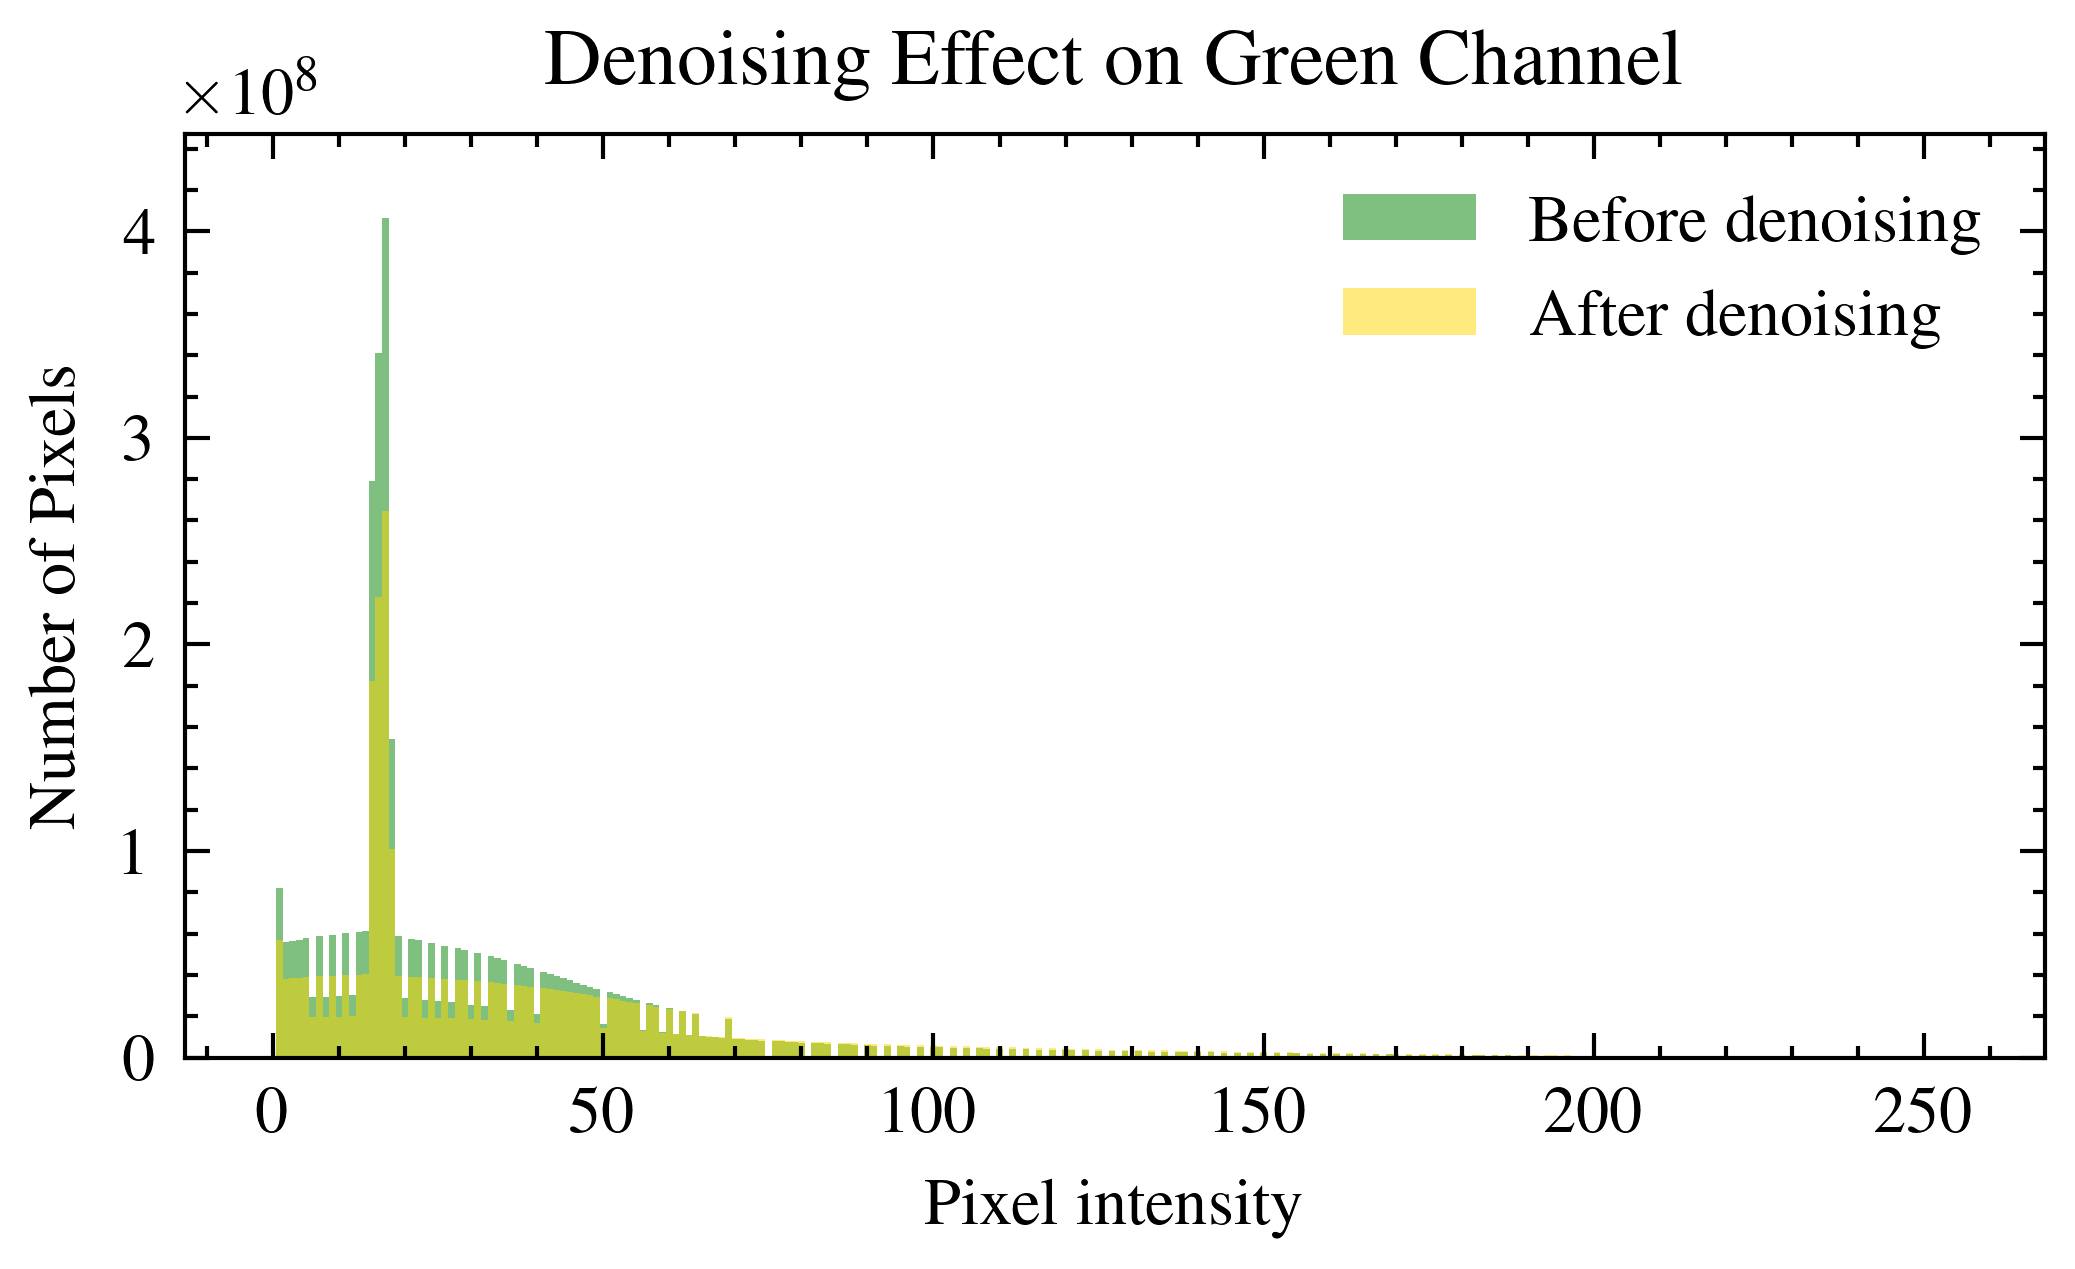

In [36]:
plt.figure(figsize=(4, 2))
x_values = np.arange(256)

plt.bar(x_values, g_combined, color='green', label='Before denoising', width=1.0, alpha=0.5)
plt.bar(x_values, g_cleaned_combined, color='gold', label='After denoising', width=1.0, alpha=0.5)

plt.title(f'Denoising Effect on Green Channel')
plt.xlabel('Pixel intensity')
plt.ylabel('Number of Pixels')
plt.legend()
plt.grid(False)

plt.ylim(0, max(max(g_combined), max(g_cleaned_combined)) * 1.1)
plt.savefig('charts/green_channel_denoising.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

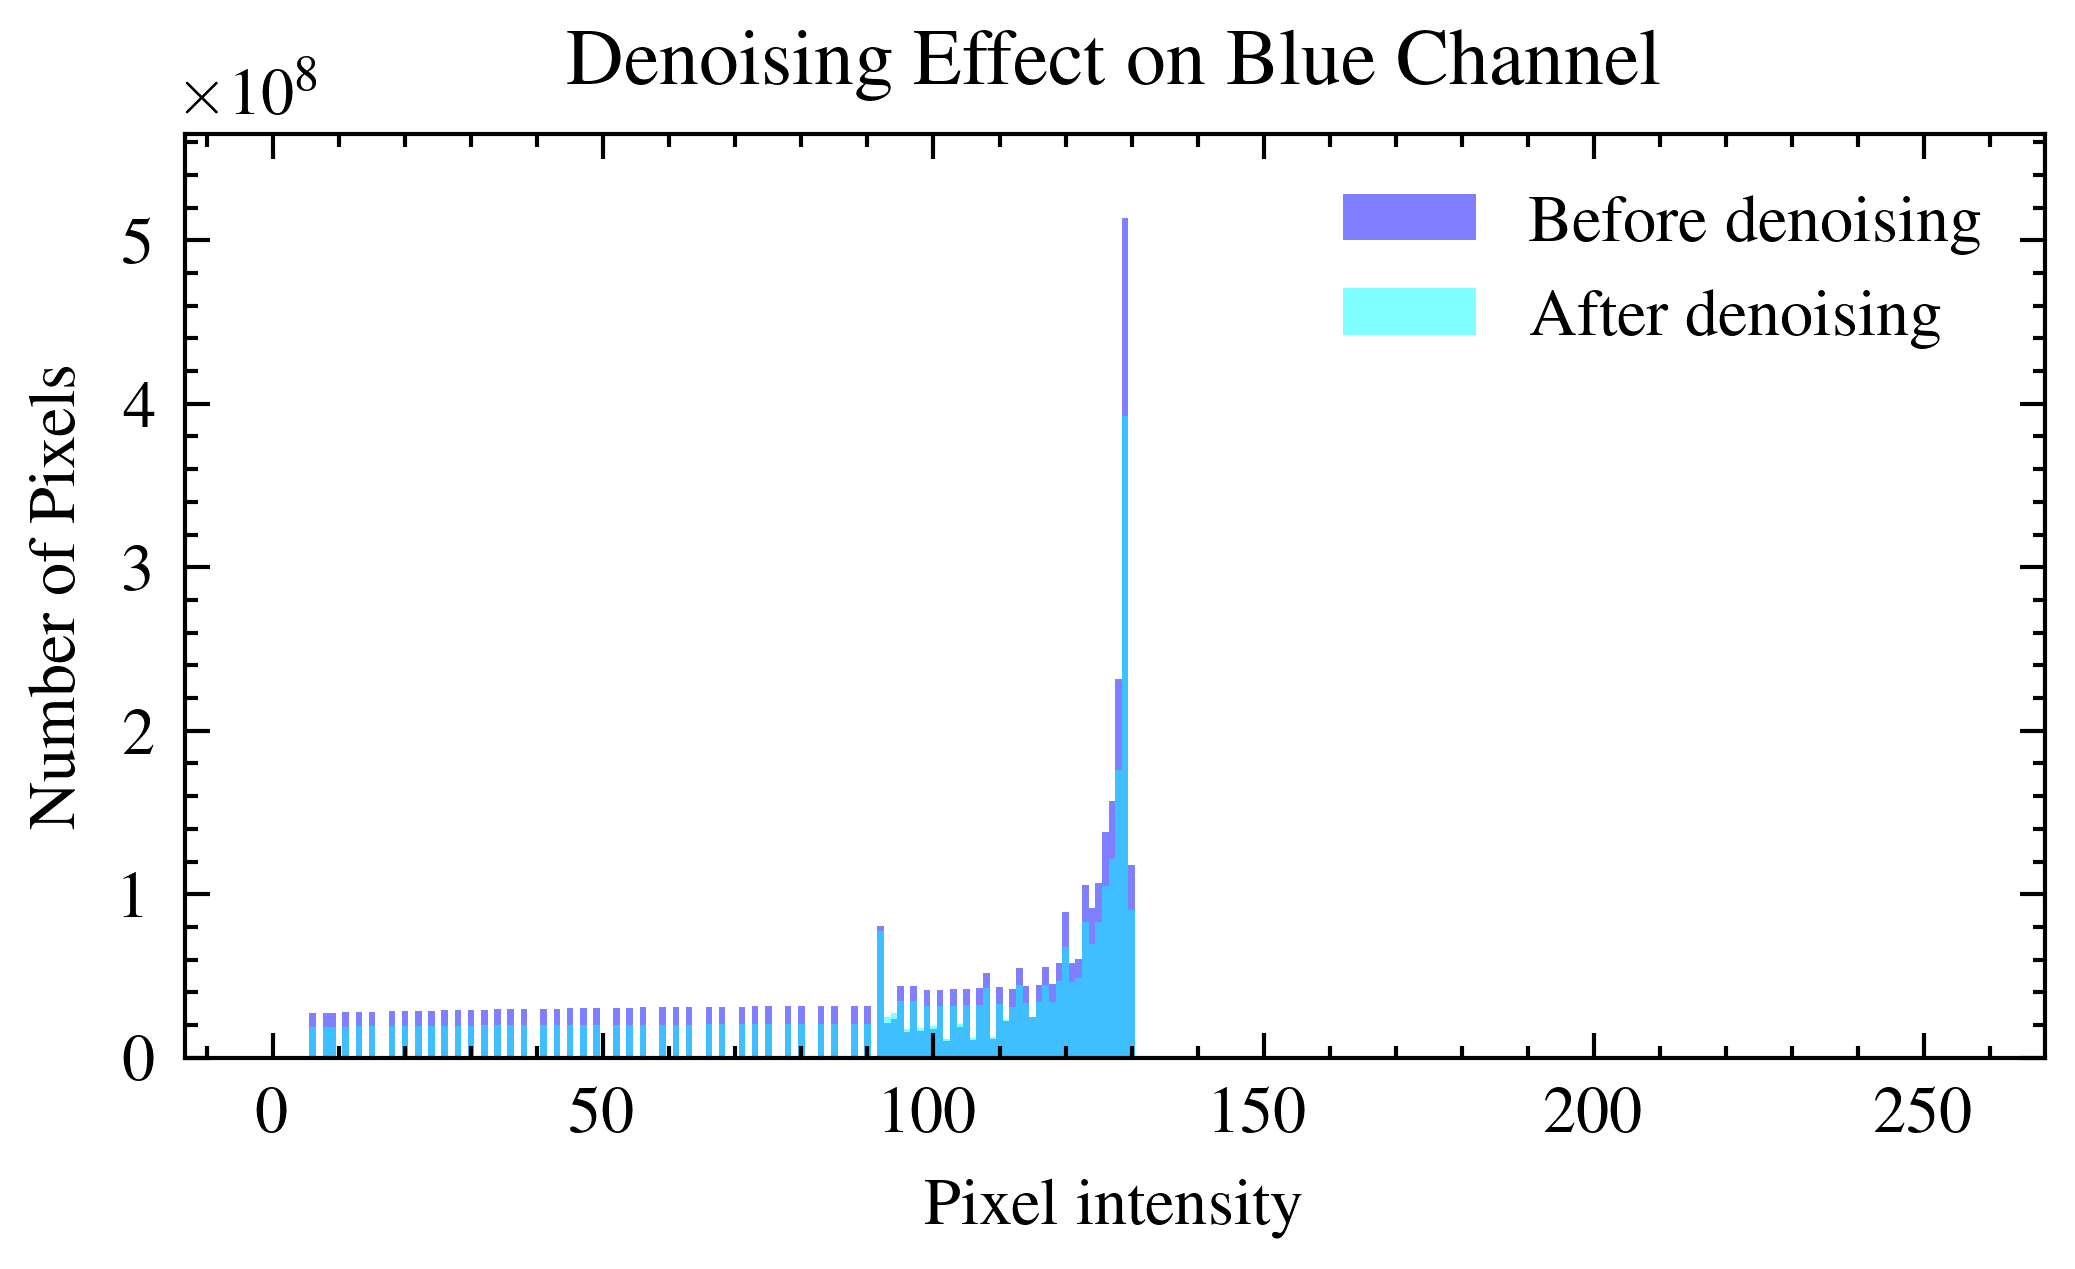

In [31]:
plt.figure(figsize=(4, 2))
x_values = np.arange(256)

plt.bar(x_values, b_combined, color='blue', label='Before denoising', width=1.0, alpha=0.5)
plt.bar(x_values, b_cleaned_combined, color='cyan', label='After denoising', width=1.0, alpha=0.5)

plt.title(f'Denoising Effect on Blue Channel')
plt.xlabel('Pixel intensity')
plt.ylabel('Number of Pixels')
plt.legend()
plt.grid(False)

plt.ylim(0, max(max(b_combined), max(b_cleaned_combined)) * 1.1)
plt.savefig('charts/blue_channel_denoising.png', dpi=300)
plt.show()